In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

#read csv
df = pd.read_csv("brain_stroke_clean.csv")

# target stroke
y = df["stroke"].astype(int).values

# one hot 
X_cat = pd.get_dummies(
    df[["work_type", "smoking_status"]].astype(str),
    prefix=["work", "smoke"]
)
# x feature get all numeric feature and drop target
num = df.select_dtypes(include=[np.number]).drop(columns=["stroke"], errors="ignore")
X = pd.concat([num, X_cat], axis=1).fillna(0.0).astype(float).values

# print original set of value
u, c = np.unique(y, return_counts=True)
print("Original class counts:", dict(zip(u, c)))

# split the data to train and test and use stratofy to scale them equal 
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X, y, test_size=0.2, random_state=43, stratify=y
)

# pritn total data after split
print("Initial split shapes ->",
      "X_train:", X_train_under.shape,
      "X_test:",  X_test_under.shape)

# undersampling the train data to fit 1:1 scale
rus = RandomUnderSampler(random_state=42)  # 1:1 
X_train_under, y_train_under = rus.fit_resample(X_train_under, y_train_under)

# feature scaling so that all feature value is no spread out
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train_under).astype("float32")
Xte = scaler.transform(X_test_under).astype("float32")

# # count and print all data fro train after undersampling and test data
train_counts = pd.Series(y_train_under).value_counts().sort_index().to_dict()
test_counts  = pd.Series(y_test_under).value_counts().sort_index().to_dict()
print("Train class counts (after undersampling):", train_counts)
print("Test  class counts (original distribution):", test_counts)

print("X_train_under.shape:", X_train_under.shape)
print("X_test_under.shape :", X_test_under.shape)


Original class counts: {np.int64(0): np.int64(4733), np.int64(1): np.int64(248)}
Initial split shapes -> X_train: (3984, 16) X_test: (997, 16)
Train class counts (after undersampling): {0: 198, 1: 198}
Test  class counts (original distribution): {0: 947, 1: 50}
X_train_under.shape: (396, 16)
X_test_under.shape : (997, 16)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

# layer and neurons
model = keras.Sequential([
    layers.Input(shape=(Xtr.shape[1],)), #one feature slot per column
    layers.Dense(64, activation="relu"), #hidden layers, give 0 for negative wont change positive number
    layers.Dense(32,  activation="relu"),
    layers.Dense(1,   activation="sigmoid") # output layers, give probability for class 1
])

#set learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy", # check loss, of too high and wrong = over confidence , big penalty
    metrics=["accuracy"]
)

# tune 
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True) # stop after not improving for 5 epoch, then roll back to best epoch
history = model.fit(Xtr, y_train_under, validation_split=0.20,
                    epochs=150, batch_size=128, callbacks=[early], verbose=0)
# predict
proba_te = model.predict(Xte)
pred_te  = (proba_te >= 0.4).astype(int) # if class 1 probality more than 0.4 means 1 or else is 0

#evaluate
acc  = accuracy_score(y_test_under, pred_te)
f1   = f1_score(y_test_under, pred_te)
cm   = confusion_matrix(y_test_under, pred_te)
report = classification_report(y_test_under, pred_te, digits=2)

print(f"Accuracy: {acc:.6f}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(report)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.352056

Confusion Matrix:
[[311 636]
 [ 10  40]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.33      0.49       947
           1       0.06      0.80      0.11        50

    accuracy                           0.35       997
   macro avg       0.51      0.56      0.30       997
weighted avg       0.92      0.35      0.47       997



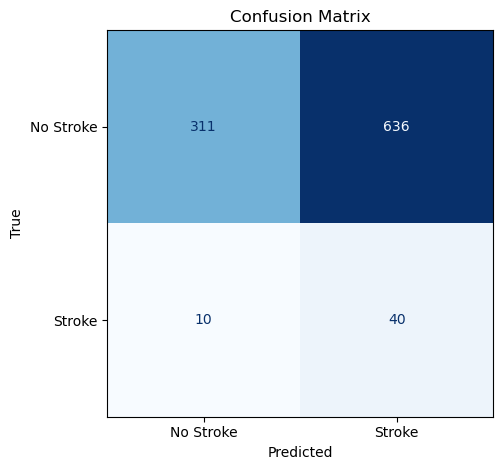

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix
cm = confusion_matrix(y_test_under, pred_te)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No Stroke", "Stroke"])
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


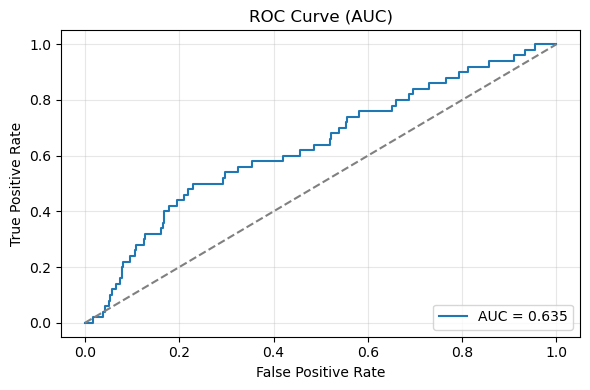

In [17]:
from sklearn.metrics import roc_curve, auc

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_under, proba_te)
roc_auc = auc(fpr, tpr)

#plot graph
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

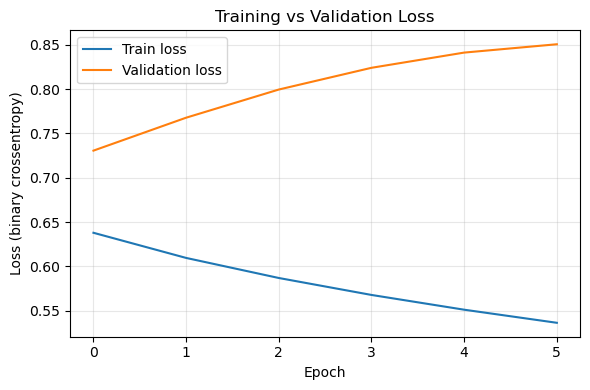

In [25]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"],     label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (binary crossentropy)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# random forest tune
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None, # No limit on how tall each tree can grow
    min_samples_leaf=5, # A leaf (final decision) must contain at least 5 training rows
    min_samples_split=10, # A node needs at least 10 training rows before it’s allowed to split.
    random_state=42,
)
rf.fit(X_train_under, y_train_under)

# predict
pred_rf = rf.predict(X_test_under)
proba_rf = rf.predict_proba(X_test_under)[:, 1]  # scores for ROC/PR

acc = accuracy_score(y_test_under, pred_rf)
f1  = f1_score(y_test_under, pred_rf)
cm  = confusion_matrix(y_test_under, pred_rf)

print(f"Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test_under, pred_rf, digits=2))

Accuracy: 0.7573
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.86       947
           1       0.15      0.82      0.25        50

    accuracy                           0.76       997
   macro avg       0.57      0.79      0.55       997
weighted avg       0.95      0.76      0.82       997



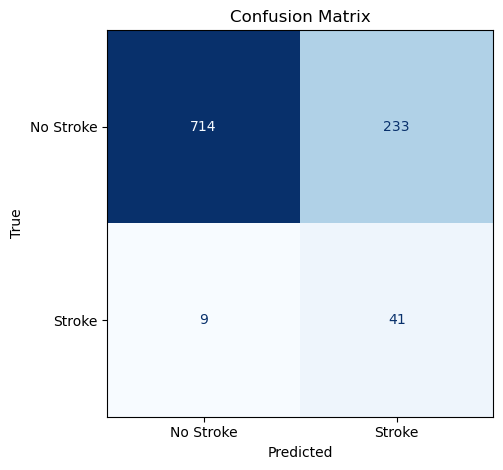

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix
cm = confusion_matrix(y_test_under, pred_rf)  # or y_pred_rf
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No Stroke", "Stroke"])
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


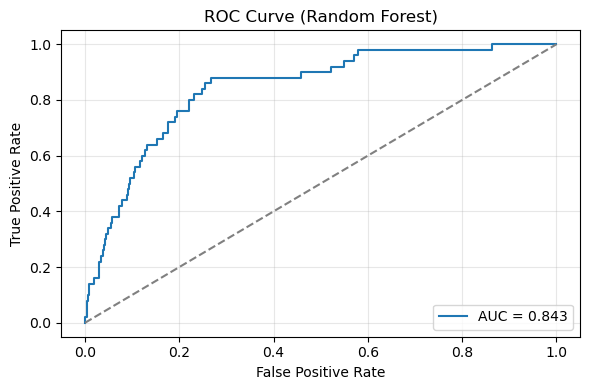

In [28]:
# plot ROC and AUC

fpr, tpr, _ = roc_curve(y_test_under, proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Stacked Ensemble: RF + MLP 
# model 1 MLP 
tf.random.set_seed(42)
mlp = keras.Sequential([
    layers.Input(shape=(Xtr.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1,  activation="sigmoid")
])
mlp.compile(optimizer=keras.optimizers.Adam(0.001),
            loss="binary_crossentropy", 
            metrics=["accuracy"])

early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                      restore_best_weights=True)

mlp.fit(Xtr, y_train_under, validation_split=0.20,
        epochs=150, batch_size=128, callbacks=[early], verbose=0)

#Base predictions (Keras gives preds like (N, 1) but sklearn likes (N,). ravel makes both match)
p_mlp_te = mlp.predict(Xte, verbose=0).ravel()

# model 2 Random Forest 
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)
rf.fit(X_train_under, y_train_under)

# predict
p_rf_te = rf.predict_proba(X_test_under)[:, 1]

# give both model equal weights
w_rf  = 0.5
w_mlp = 0.5
#combine them
p_stack_te = w_rf * p_rf_te + w_mlp * p_mlp_te #RF=0.30, MLP=0.80 > combined = 0.55.

# predictions & metrics
pred_stack = (p_stack_te >= 0.5).astype(int)

acc  = accuracy_score(y_test_under, pred_stack)
f1   = f1_score(y_test_under, pred_stack)
cm   = confusion_matrix(y_test_under, pred_stack)
rep  = classification_report(y_test_under, pred_stack, digits=2)

print("STACKED ENSEMBLE ")
print(f"Accuracy: {acc:.4f}")
print(f"F1 (positive class): {f1:.4f}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(rep)


STACKED ENSEMBLE 
Accuracy: 0.7372
F1 (positive class): 0.2471

Confusion Matrix:
[[692 255]
 [  7  43]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       947
           1       0.14      0.86      0.25        50

    accuracy                           0.74       997
   macro avg       0.57      0.80      0.54       997
weighted avg       0.95      0.74      0.81       997



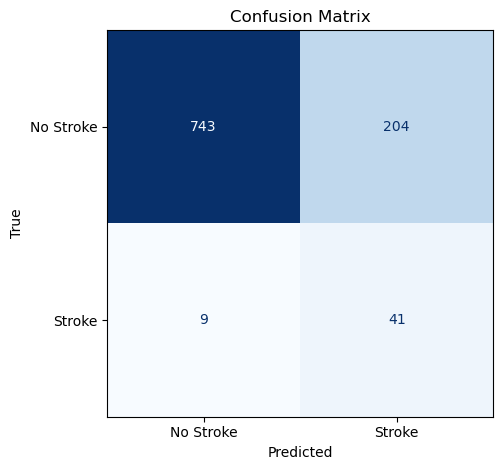

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_under, pred_stack)  # or y_pred_rf
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No Stroke", "Stroke"])
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


AUC  MLP: 0.682 | RF: 0.843 | Ensemble: 0.848


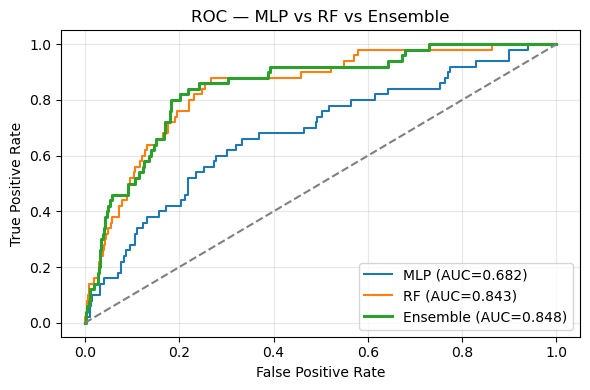

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# --- AUC numbers ---
auc_mlp   = roc_auc_score(y_test_under, p_mlp_te)
auc_rf    = roc_auc_score(y_test_under, p_rf_te)      # was proba_rf
auc_stack = roc_auc_score(y_test_under, p_stack_te)
print(f"AUC  MLP: {auc_mlp:.3f} | RF: {auc_rf:.3f} | Ensemble: {auc_stack:.3f}")

# --- ROC curves (MLP, RF, Ensemble) ---
fpr_m, tpr_m, _ = roc_curve(y_test_under, p_mlp_te)
fpr_r, tpr_r, _ = roc_curve(y_test_under, p_rf_te)
fpr_s, tpr_s, _ = roc_curve(y_test_under, p_stack_te)

plt.figure(figsize=(6,4))
plt.plot(fpr_m, tpr_m, label=f"MLP (AUC={auc_mlp:.3f})")
plt.plot(fpr_r, tpr_r, label=f"RF (AUC={auc_rf:.3f})")
plt.plot(fpr_s, tpr_s, label=f"Ensemble (AUC={auc_stack:.3f})", linewidth=2.2)
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — MLP vs RF vs Ensemble")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
